In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.12.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


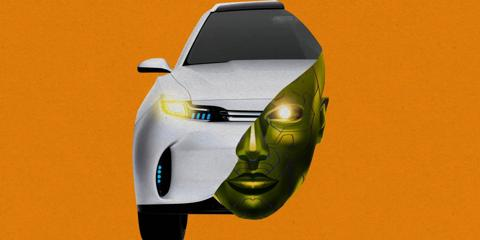

[China EV makers pivot to robots](https://www.technologyreview.com/2025/02/18/1111964/inside-chinas-electric-vehicle-to-humanoid-robot-pivot/) - MIT Technology Review

___

[Using AI to detect domestic violence](https://www.fastcompany.com/91280559/automated-intimate-partner-violence-risk-support-system)

___

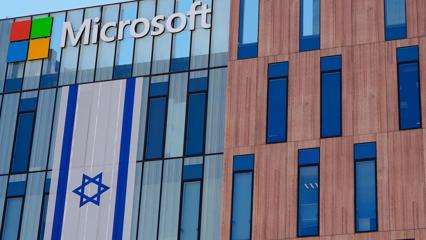

[As Israel uses US-made AI models in war, concerns arise about tech’s role in who lives and who dies](https://abcnews.go.com/Technology/wireStory/israel-us-made-ai-models-war-concerns-arise-118917652) - ABC News

___

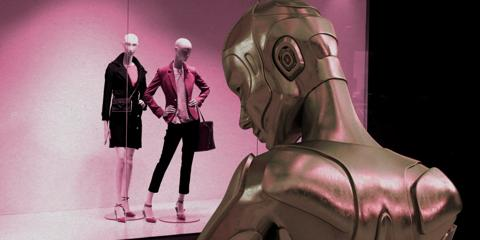

[Your most important customer may be AI](https://www.technologyreview.com/2025/02/19/1112076/your-most-important-customer-may-be-ai/) - MIT Technology Review

___

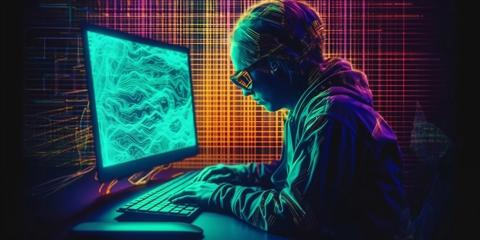

[AI can’t find the root cause of bugs, but might fix them if you tell them how.](https://venturebeat.com/ai/ai-can-fix-bugs-but-cant-find-them-openais-study-highlights-limits-of-llms-in-software-engineering/) - VentureBeat

___

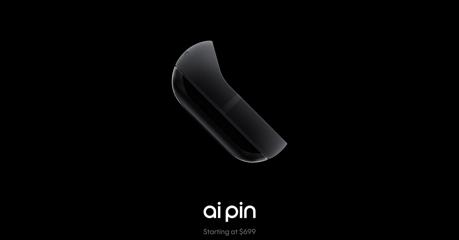

[Humane’s AI Pin is dead after fire sale](https://www.theverge.com/2023/11/9/23954497/humane-ai-pin-wearable-news-announcements) - The Verge

___

[Mira Murati's company is called Thinking Machines Lab. 

(a nod to the old Thinking Machines of the Connection Machine parallel computer?)](https://www.nytimes.com/2025/02/18/technology/openai-mira-murati-startup.html)

___

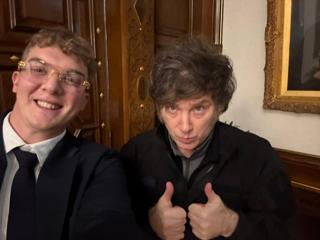

[Newsletter: A major crypto scandal tarnishes the reputation of Solana bigwigs, crypto influencers, and Argentine President Javier Milei.

“This is FTX type of shit,” said a crypto founder confronting Meteora’s Ben Chow over alleged insider trading.

www.citationneeded.news/issue-77/](https://www.citationneeded.news/issue-77/) - Citation Needed

___

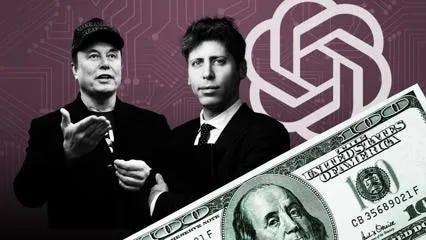

[Today's substack, which is basically a lightly edited version of bleats from past 24h](https://www.skynetandchill.com/p/ai-reading-for-tuesday-february-18)

___

[A \\$35B, 3GW AI Data Center Is Planned for South Korea](https://www.wsj.com/tech/ai/ai-data-center-with-up-to-3-gigawatts-of-power-is-envisioned-for-south-korea-5141bd77)

___

[Robot submarines to patrol the oceans and protect cables and infrastructure](https://www.wsj.com/tech/ai/ai-military-applications-mapping-aca7f486)

___

[How to learn to work with your new AI coworker](https://www.fastcompany.com/91276144/how-to-learn-to-work-with-your-new-ai-coworker)

___

[Google’s AI Efforts Marred by Turf Disputes](https://www.theinformation.com/articles/googles-ai-efforts-marred-by-turf-disputes)

___

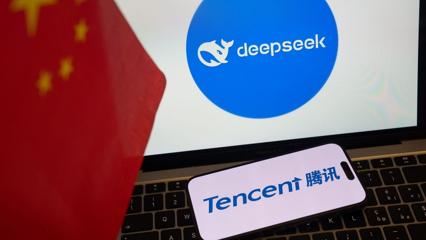

[Tencent will use DeepSeek in addition to its own model](https://www.ft.com/content/9e7cbab3-0c1b-49ad-8f94-4d443a6a8ad0)

___

[Watch the video if you are into it, not very watchable to me or a lot of people, viewer count declined gradually](https://x.com/xai/status/1891699715298730482) - X (formerly Twitter)

___

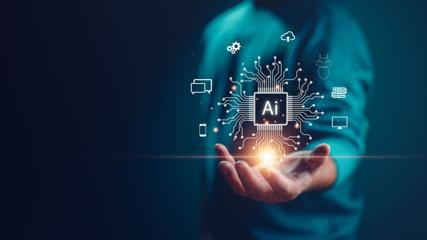

[As cheap as DeepSeek supposedly was, it's still an awfully heavy lift for enterprises to maintain their own models.](https://www.techradar.com/pro/your-ai-your-rules-why-byo-llm-bring-your-own-llm-is-the-future) - TechRadar

___

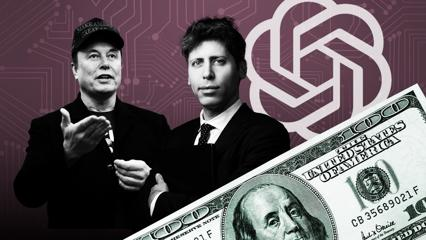

[OpenAI looks for possible governance poison pills to fend off hostile takeover from Elon Musk](https://www.ft.com/content/5af7279f-5996-46f8-a7b9-f35d966880a0)

___

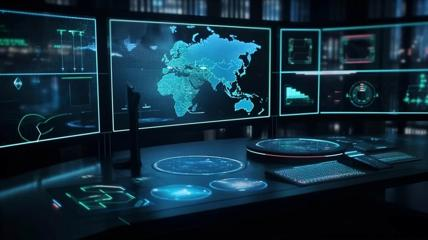

[10 Key Security Operations Center Challenges and How AI Helps Address Them](https://hackread.com/10-key-soc-challenges-and-how-ai-addresses-them/) - Hackread - Latest Cybersecurity, Tech, AI, Crypto & Hacking News

___

[AI Companions: the future of friendship or a dangerous illusion?

Sometimes talking things through with AI could help dealing with messy situations and peope, but also seems likely people might learn to relate to AI companions in ways that make it harder for them to deal with real people.](https://www.fastcompany.com/91279582/ai-companions-the-future-of-friendship-or-a-dangerous-illusion)

___

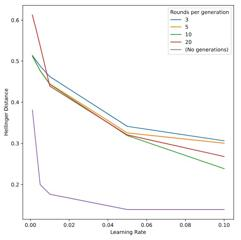

[How AI Is Narrowing Our View of the World. 

How much expert human content and correcting AI that goes off the rails is needed to avoid an AI game of telephone and knowledge collapse in the information ecosystem?](https://hackernoon.com/how-ai-is-narrowing-our-view-of-the-world)

___

I'm not sure xAI will do that immediately. They might pitch (cough-pressure) cloud platforms for a deal similar to what OpenAI does with Azure. If customers want Grok then AWS/GCP will be very receptive to be more competitive with Azure.

I think if he wants to really make an impact and stick it to OpenAI, has to steal a page from DeepSeek's playbook and make an excellent open source model available, let enterprises use it in Azure and AWS and GCP. The appetite to send your intellectual property to another platform is low.

[Some coverage of the demo and pricing, can't use beta without an X subscription](https://www.theregister.com/2025/02/18/grok_3/)

___

I probably wouldn't want to be the industry guy or journo who says it's not all it's cracked up to be.

[Karpathy says it's pretty pretty good](https://x.com/karpathy/status/1891720635363254772) - X (formerly Twitter)

___

tied for math. 

wins 51% against OpenAI's top model, so you swing 1% of votes, < 100 overall, 3-4 head to head, it goes the other way, not that anyone would do that of course.

Maybe Sam Altman's wish that Elon Musk would compete on  product was granted. Given the scrupulous honesty in all of Elon Musk's words and actions, his sense of fair play toward OpenAI, I'm sure there were no shenanigans LOL, wouldn't be crazy hard to de-anonymize using AI or a backdoor ping.

[Grok leads Chatbot arena by a little bit across all categories.](https://lmarena.ai/?leaderboard)

___

Grok 3 allegedly coming at 11pm EST, don't wait up

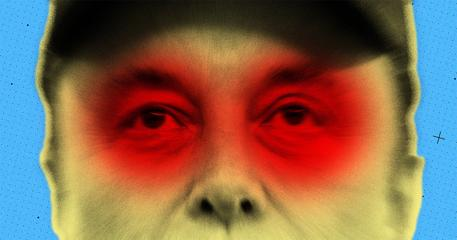

[Free speech extremist sacks engineer over a tweet](https://futurism.com/elon-musk-xai-sacks-engineer) - Futurism

___

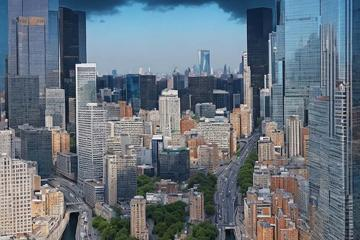

[AI-generated optical illusions can sort humans from bots](https://www.newscientist.com/article/2468020-ai-generated-optical-illusions-can-sort-humans-from-bots/) - New Scientist

___

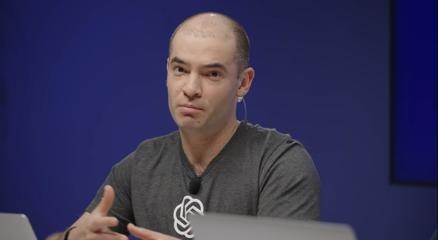

[Ilya Sutskever's Safe Superintelligence reportedly raising \\$1B+ on \\$30B valuation](https://siliconangle.com/2025/02/17/ilya-sutskevers-safe-superintelligence-reportedly-raising-1b-30b-valuation/) - SiliconANGLE

___

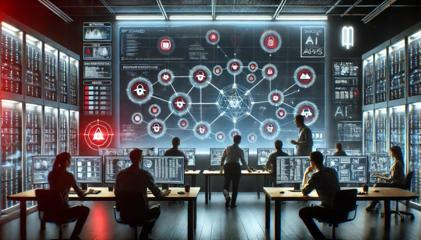

[Unapproved 'shadow AI' creates reputational risks, IP leaks, IT headaches](https://venturebeat.com/security/shadow-ai-unapproved-ai-apps-compromising-security-what-you-can-do-about-it/) - VentureBeat

___

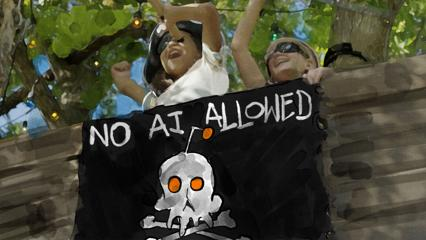

[Reddit mods struggle with AI slop, want better tools](https://arstechnica.com/gadgets/2025/02/reddit-mods-are-fighting-to-keep-ai-slop-off-subreddits-they-could-use-help/) - Ars Technica

___

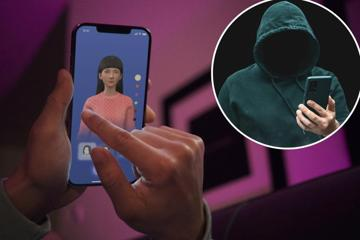

[Creepy men create AI girlfriends and verbally abuse them](https://nypost.com/2025/02/16/lifestyle/lonely-men-are-creating-ai-girlfriends-and-taking-their-violent-anger-out-on-them/) - New York Post

___

[People intuitively get slack when they buy from the name brand that offers free returns but is not the lowest cost. Midwit bean counters over-optimize and don't back off from overfitted solutions www.resilience-engineering-association.org/blog/2021/01...](https://www.resilience-engineering-association.org/blog/2021/01/12/slack-a-key-enabler-of-resilient-performance/)

___

You build roads with shoulders, you have 2 means of egress and you do fire drills so there is capacity that doesn't get used every day but is there when you need it.  When you don't have slack in a complex system, it becomes unpredictable or totally breaks down the first time it's overloaded.

You could use AI to run tough simulations of 9/11s and zombie apocalypses and Kobayashi Marus sand have the smartest work force ever. Or you could employ the minimum number of low-wage mouse-clickers to keep AI happy. Until the assumptions of AI no longer hold and it all comes to a sudden stop.

cannot identify image file 'tmp/source38.html; charset=utf-8'


[Why Johnny can't code: Copilot](https://nmn.gl/blog/ai-and-learning) - N’s Blog

___

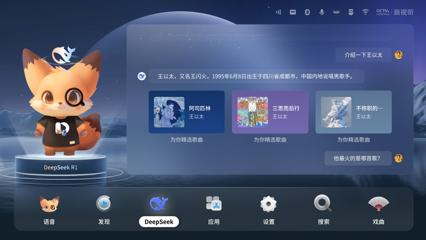

[Chinese companies rush to incorporate DeepSeek in products and online services](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content) - Tom's Hardware

___

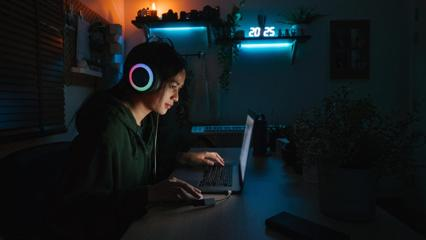

[How to Use AI to Write a Cover Letter](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/) - CNET

___

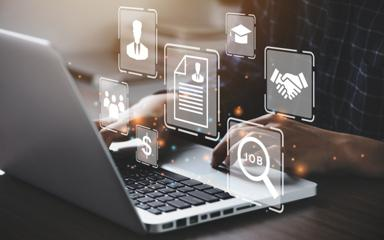

[How candidates can hack HR AI and get hired](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/) - San Diego Union-Tribune

___

[How to use AI to find new movies, music, and books](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books)

___

[AI agents start to talk to customers](https://www.wsj.com/business/ai-agents-customer-service-b4dc99e5)

___

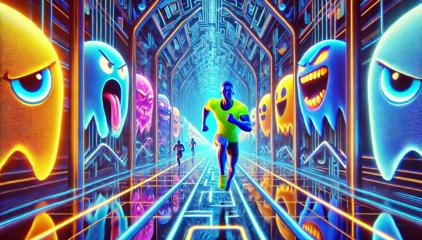

[AI is studying you and learning how to influence you](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/) - VentureBeat

___

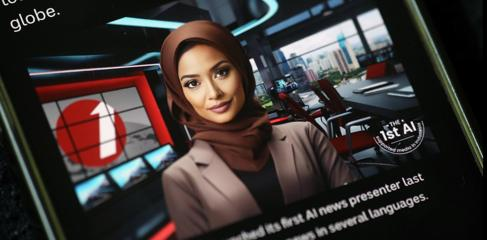

[Generative AI is already being used in journalism, APO report covers use cases and how people feel about them](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232) - The Conversation

___

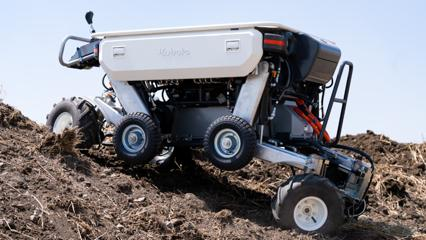

[5 high-tech robots that are changing how we grow our food](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/) - The Cool Down

___

[New York Times brings an AI tool to its newsroom.

OpenAI lawyers might have some questions about whether it is responsibly sourced.](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/)

___

["AI gaydar for middle managers"](https://pluralistic.net/2025/02/17/caliper-ai/#racism-machine)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-02-19 10:24:57.725668


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 2, 19, 15, 24, 6, 933000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-02-18 04:24:57.729978


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined